# Couple Candlesticks - Strategy - Backtesting 

### Import Library

In [49]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy
from backtesting._plotting import set_bokeh_output
set_bokeh_output(notebook=False)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')

### Load Price Data

In [50]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

In [51]:
data = dataset.copy()

In [52]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2020-11-01 00:00:00']
# data = data[data.index > '2024-01-01 00:00:00']

In [53]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2024-11-12 14:15:00,1306.4,1309.4,1304.6,1304.7,8733
2024-11-12 14:20:00,1304.7,1307.4,1302.7,1306.5,10758
2024-11-12 14:25:00,1306.9,1309.4,1306.2,1309.1,9066


In [54]:
def set_condition_1(r):
    cond = ''
    if r['Open'] > r['Close'] and r['Close'] >= r['Low'] + 0.1:
        # Do va co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] and r['Close'] <= r['High'] - 0.1:
        # Xanh va co bong nen tren
        cond = 'long'
    return cond

def set_condition_2(r):
    cond = ''
    if r['Open'] > r['Close'] and r['Close'] == r['Low'] and r['Low'] < r['prev_low']:
        # Do va khong co bong nen duoi
        cond = 'short'
    elif r['Open'] < r['Close'] and r['Close'] == r['High']  and r['High'] > r['prev_high']:
        # Xanh va khong co bong nen tren
        cond = 'long'
    return cond

def get_signal(r):
    signal = ''
    if r['condition_1'] == 'short' and r['condition_2'] == 'short':
        signal = 'short'
    elif r['condition_1'] == 'long' and r['condition_2'] == 'long':
        signal = 'long'
    return signal

In [55]:
def prepare_data(data):
    data['rsi'] = ta.rsi(data["Close"], length=14)
    data['prev_low'] = data['Low'].shift(1)
    data['prev_high'] = data['High'].shift(1)
    data['max_5'] = data['High'].rolling(5).max()
    data['min_5'] = data['Low'].rolling(5).min()
    data['condition_1'] = data.apply(lambda r: set_condition_1(r), axis=1)
    data['condition_1'] = data['condition_1'].shift(1)
    data['condition_2'] = data.apply(lambda r: set_condition_2(r), axis=1)
    data['signal'] = data.apply(lambda r: get_signal(r), axis=1)
    return data

In [56]:
class CoupleCandlesticks(Strategy):
    max_sl = 3.5
    trailing_sl = 4.5
    tp_step = 20
    def init(self):
        super().init()

    def next(self):
        super().next()
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 25:
            if self.position.is_long or self.position.is_short:
                self.position.close()
                return
                
        if current_time.hour == 14 and current_time.minute >= 30:
            return

        close_price = self.data.Close[-1]
        if self.position.is_long:
            max_5 = self.data.max_5[-1]
            if close_price < max_5 - self.trailing_sl:
                self.position.close()
        elif self.position.is_short:
            min_5 = self.data.min_5[-1]
            if close_price > min_5 + self.trailing_sl:
                self.position.close()

        if self.position:
            return  
        signal = self.data.signal[-1]
        if signal == 'long':
            buy_price = close_price
            min_5 = self.data.min_5[-1]
            tmp_risk = buy_price - min_5
            risk = min(tmp_risk, self.max_sl)
            sl = buy_price - risk
            tp = buy_price + self.tp_step
            self.buy(size=1, sl=sl, tp=tp)
        elif signal == 'short':
            sell_price = close_price
            max_5 = self.data.max_5[-1]
            tmp_risk = max_5 - sell_price
            risk = min(tmp_risk, self.max_sl)
            sl = sell_price + risk
            tp = sell_price - self.tp_step
            self.sell(size=1, sl=sl, tp=tp)

In [57]:
prepared_data = prepare_data(data)
prepared_data.dropna(inplace=True)

In [58]:
# prepared_data[(prepared_data.index > '2024-11-06 00:00:00') & (prepared_data.index < '2024-11-06 15:00:00')]

In [59]:
bt = Backtest(prepared_data, CoupleCandlesticks, commission=.0003, exclusive_orders=True)
stats = bt.run()
# bt.plot()
print(stats)

Start                     2020-11-02 10:10:00
End                       2024-11-12 14:45:00
Duration                   1471 days 04:35:00
Exposure Time [%]                   33.413232
Equity Final [$]                  10631.45788
Equity Peak [$]                   10653.46022
Return [%]                           6.314579
Buy & Hold Return [%]                45.60409
Return (Ann.) [%]                     1.55168
Volatility (Ann.) [%]                1.106475
Sharpe Ratio                         1.402363
Sortino Ratio                        2.808624
Calmar Ratio                         1.957288
Max. Drawdown [%]                    -0.79277
Avg. Drawdown [%]                   -0.066898
Max. Drawdown Duration      384 days 00:05:00
Avg. Drawdown Duration        7 days 01:34:00
# Trades                                 1556
Win Rate [%]                        34.768638
Best Trade [%]                       2.295959
Worst Trade [%]                     -0.920813
Avg. Trade [%]                    

In [60]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
0,1,35,36,906.97201,904.0,-2.97201,-0.003277,2020-11-02 14:30:00,2020-11-02 14:45:00,None,0 days 00:15:00
1,-1,42,55,907.92754,909.4,-1.47246,-0.001622,2020-11-03 09:25:00,2020-11-03 10:30:00,None,0 days 01:05:00
2,-1,96,101,907.02781,908.8,-1.77219,-0.001954,2020-11-04 09:40:00,2020-11-04 10:05:00,None,0 days 00:25:00
3,1,102,136,909.37273,912.5,3.12727,0.003439,2020-11-04 10:10:00,2020-11-04 14:25:00,None,0 days 04:15:00
4,1,230,239,906.97201,910.5,3.52799,0.003890,2020-11-06 13:45:00,2020-11-06 14:30:00,None,0 days 00:45:00
...,...,...,...,...,...,...,...,...,...,...,...
1551,-1,51079,51087,1326.00208,1327.4,-1.39792,-0.001054,2024-11-06 10:35:00,2024-11-06 11:15:00,None,0 days 00:40:00
1552,1,51125,51151,1338.50143,1337.2,-1.30143,-0.000972,2024-11-07 10:10:00,2024-11-07 13:45:00,None,0 days 03:35:00
1553,-1,51178,51211,1334.09965,1324.3,9.79965,0.007346,2024-11-08 10:20:00,2024-11-08 14:30:00,None,0 days 04:10:00
1554,-1,51232,51254,1313.00598,1311.8,1.20598,0.000918,2024-11-11 10:35:00,2024-11-11 13:50:00,None,0 days 03:15:00


In [61]:
stats['_trades']['PnL'].sum()

631.457880000052

In [62]:
trades = stats['_trades']

In [63]:
trades['cum_sum'] = trades['PnL'].cumsum()
X = np.array(range(0, len(trades['cum_sum'])))
Y = trades['cum_sum']

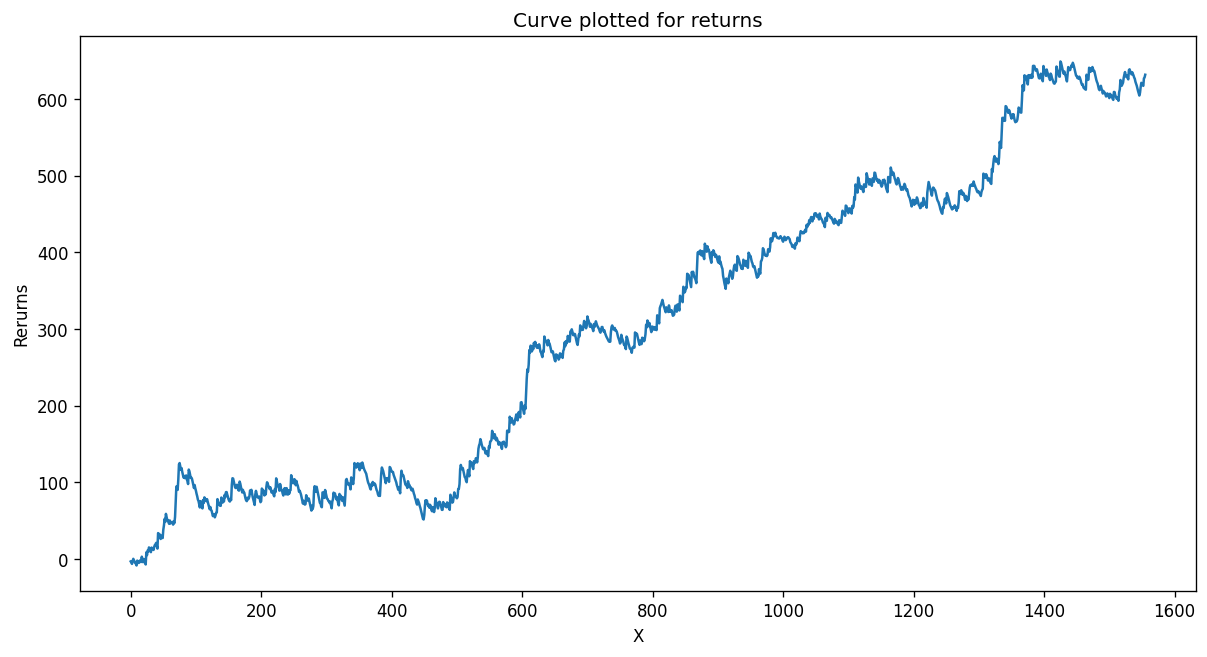

In [64]:
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()

In [65]:
# Long
trades[trades.Size==1]['PnL'].sum()

333.860930000026

In [66]:
# Short
trades[trades.Size==-1]['PnL'].sum()

297.596950000026

In [69]:
trades['EntryTime'] = trades['EntryTime'] - pd.DateOffset(minutes=5)
join_trades = pd.merge(trades, data, left_on="EntryTime", right_index=True, how="left")

In [71]:
join_trades['rsi'] = join_trades['rsi'].round(0)

In [72]:
join_trades

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,...,Close,Volume,rsi,prev_low,prev_high,max_5,min_5,condition_1,condition_2,signal
0,1,35,36,906.97201,904.0,-2.97201,-0.003277,2020-11-02 14:25:00,2020-11-02 14:45:00,None,...,907.0,5873.0,68.0,899.0,905.5,907.0,896.6,long,long,long
1,-1,42,55,907.92754,909.4,-1.47246,-0.001622,2020-11-03 09:20:00,2020-11-03 10:30:00,None,...,908.1,847.0,64.0,908.3,908.9,909.4,908.1,short,short,short
2,-1,96,101,907.02781,908.8,-1.77219,-0.001954,2020-11-04 09:35:00,2020-11-04 10:05:00,None,...,907.3,1361.0,47.0,907.5,908.4,908.8,907.3,short,short,short
3,1,102,136,909.37273,912.5,3.12727,0.003439,2020-11-04 10:05:00,2020-11-04 14:25:00,None,...,909.0,1800.0,58.0,907.9,908.6,909.0,906.8,long,long,long
4,1,230,239,906.97201,910.5,3.52799,0.003890,2020-11-06 13:40:00,2020-11-06 14:30:00,None,...,906.7,2806.0,46.0,903.5,905.0,907.3,903.3,long,long,long
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,-1,51079,51087,1326.00208,1327.4,-1.39792,-0.001054,2024-11-06 10:30:00,2024-11-06 11:15:00,None,...,1326.5,1285.0,60.0,1326.6,1327.4,1327.4,1325.9,short,short,short
1552,1,51125,51151,1338.50143,1337.2,-1.30143,-0.000972,2024-11-07 10:05:00,2024-11-07 13:45:00,None,...,1338.1,1990.0,56.0,1336.7,1337.5,1338.1,1335.7,long,long,long
1553,-1,51178,51211,1334.09965,1324.3,9.79965,0.007346,2024-11-08 10:15:00,2024-11-08 14:30:00,None,...,1334.5,2171.0,39.0,1335.2,1336.2,1336.3,1334.5,short,short,short
1554,-1,51232,51254,1313.00598,1311.8,1.20598,0.000918,2024-11-11 10:30:00,2024-11-11 13:50:00,None,...,1313.0,4141.0,17.0,1313.7,1315.3,1319.7,1313.0,short,short,short


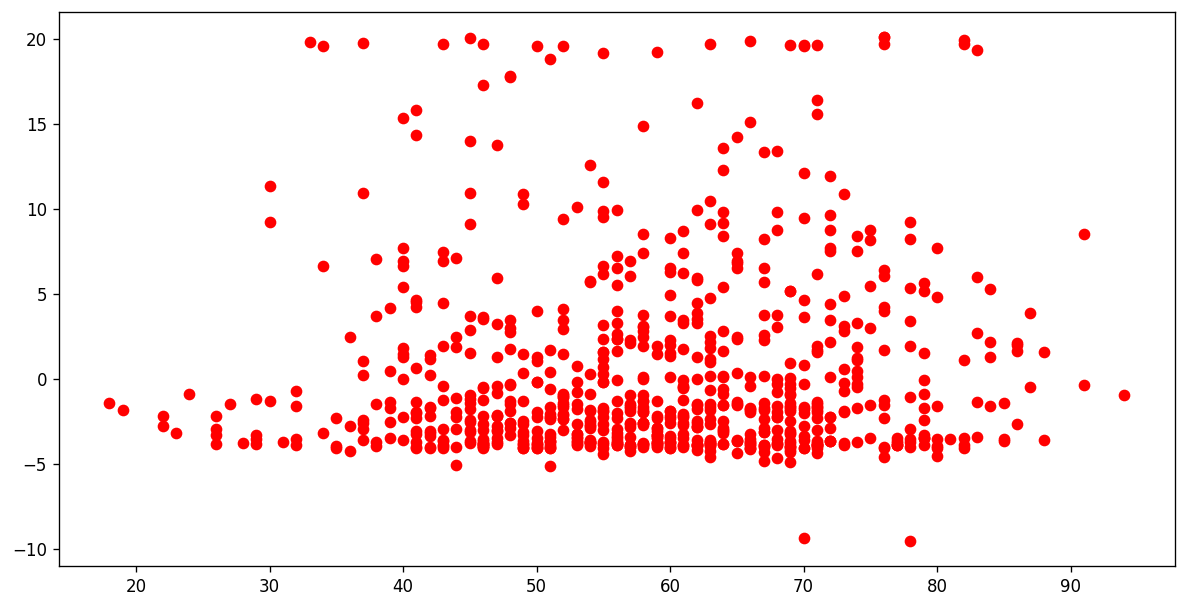

In [76]:
long_trades = join_trades[join_trades.Size==1]
plt.scatter(long_trades['rsi'], long_trades['PnL'], color='red')

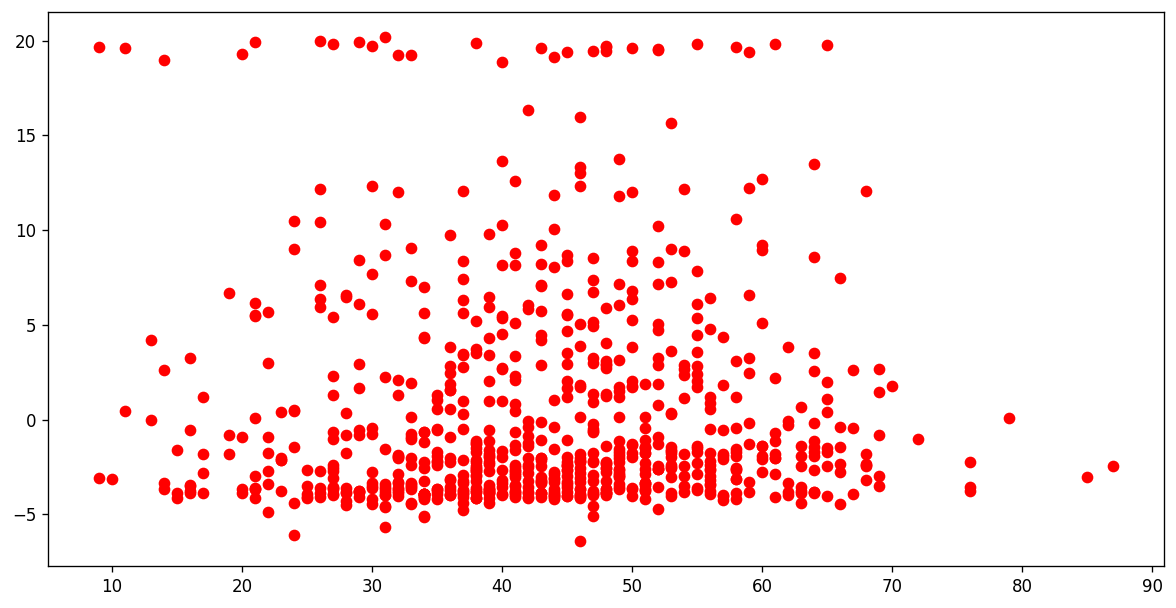

In [77]:
short_trades = join_trades[join_trades.Size==-1]
plt.scatter(short_trades['rsi'], short_trades['PnL'], color='red')